# STAT6289 Homework 4

In this homework, I tried to build up the first GAN in my life. GAN is an unsupervised deep learning algorithm where we have a **generater** against an adversarial network called **discriminator**. Generator's objective is to generate data that is very similar to the training data. The ideal case would be that data generated from genrator should be indistinguishable from the real data. Discriminator takes two sets of input, one is from the training data (real data) and the other is the generated data from the generator. \\

In this homework, I will use the **MNIST** data and at the end I will show how the generators are able to generate real-looking MNIST digits.

First of all, let's import the required libraries.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential 
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In order to load the data from MNIST, we create a function `load_data()` function.

In [10]:
def load_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  
  # normalize images
  x_train = (x_train.astype(np.float32) - 127.5)/127.5

  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train, x_test, y_test)

(X_train, y_train, X_test, y_test) = load_data()
print(X_train.shape)

(60000, 784)


I will use Adam optimizer as it is computationally efficient and has very little memory requirement. 

In [11]:
LR = 0.0002  # initial learning rate
B1 = 0.5  # momentum term
def adam_optimizer():
  return Adam(learning_rate=LR, beta_1=B1) 

Generator is created using Multilayer Perceptron (MLP).

In [12]:
def create_generator():
  generator = Sequential()

  generator.add(Dense(units=256, input_dim = 100))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(units=512))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(units=1024))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(units=784, activation='tanh'))

  generator.compile(loss='binary_crossentropy', optimizer = adam_optimizer())

  return generator

g = create_generator()
g.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 784)              

Discriminator is also created as MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from generator.

In [13]:
def create_discriminator():
  discriminator = Sequential()

  discriminator.add(Dense(units=1024, input_dim = 784))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(units=512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(units=256))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(units=1, activation = 'sigmoid'))

  discriminator.compile(loss='binary_crossentropy', optimizer = adam_optimizer())

  return discriminator

d = create_discriminator()
d.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

Then I combine the generator and discriminator to create GAN. Noised image of shape 100 will be input to the generator and the outpt generated from the generator will be fed to the discriminator. Discriminator is froze when the generator is being trained.

In [14]:
def create_gan(discriminitor, generator):
  discriminitor.trainable = False
  gan_input = Input(shape=(100,))
  x = generator(gan_input)
  gan_output = discriminitor(x)
  gan = Model(inputs = gan_input, outputs = gan_output)
  gan.compile(loss = 'binary_crossentropy', optimizer = adam_optimizer())
  return gan

gan = create_gan(d, g)
gan.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Before training the model, I write a function  `plot_generated_images` to plot teh generated images.

In [15]:
def plot_generated_images(epoch, generator, examples = 100, dim = (10, 10), figsize = (10, 10)):
  noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(100, 28, 28)
  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('gan_generated_image %d.png' %epoch)

Finally the model is trained.

  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1


  1%|          | 2/256 [00:00<00:13, 19.39it/s]

Epoch 2


  1%|          | 2/256 [00:00<00:12, 19.76it/s]

Epoch 3


  1%|          | 2/256 [00:00<00:13, 19.46it/s]

Epoch 4


  1%|          | 2/256 [00:00<00:13, 18.19it/s]

Epoch 5


  1%|          | 2/256 [00:00<00:13, 18.70it/s]

Epoch 6


  1%|          | 2/256 [00:00<00:13, 18.37it/s]

Epoch 7


  1%|          | 2/256 [00:00<00:16, 15.81it/s]

Epoch 8


  1%|          | 2/256 [00:00<00:13, 18.72it/s]

Epoch 9


  1%|          | 2/256 [00:00<00:13, 18.48it/s]

Epoch 10


  1%|          | 2/256 [00:00<00:16, 15.74it/s]

Epoch 11


  1%|          | 2/256 [00:00<00:13, 18.85it/s]

Epoch 12


  1%|          | 2/256 [00:00<00:16, 15.69it/s]

Epoch 13


  1%|          | 2/256 [00:00<00:13, 18.57it/s]

Epoch 14


  1%|          | 2/256 [00:00<00:12, 19.64it/s]

Epoch 15


  1%|          | 2/256 [00:00<00:14, 17.46it/s]

Epoch 16


  1%|          | 2/256 [00:00<00:16, 15.45it/s]

Epoch 17


  1%|          | 2/256 [00:00<00:15, 16.88it/s]

Epoch 18


  1%|          | 2/256 [00:00<00:13, 18.45it/s]

Epoch 19


  1%|          | 2/256 [00:00<00:15, 16.29it/s]

Epoch 20


  1%|          | 2/256 [00:00<00:13, 18.22it/s]

Epoch 21


  1%|          | 2/256 [00:00<00:13, 18.57it/s]

Epoch 22


  1%|          | 2/256 [00:00<00:13, 18.27it/s]

Epoch 23


  1%|          | 2/256 [00:00<00:14, 17.16it/s]

Epoch 24


  1%|          | 2/256 [00:00<00:15, 16.71it/s]

Epoch 25


  1%|          | 2/256 [00:00<00:14, 18.14it/s]

Epoch 26


  1%|          | 2/256 [00:00<00:14, 17.36it/s]

Epoch 27


  1%|          | 2/256 [00:00<00:14, 17.16it/s]

Epoch 28


  1%|          | 2/256 [00:00<00:14, 17.68it/s]

Epoch 29


  1%|          | 2/256 [00:00<00:15, 16.81it/s]

Epoch 30


  1%|          | 2/256 [00:00<00:14, 17.49it/s]

Epoch 31


  1%|          | 2/256 [00:00<00:14, 17.83it/s]

Epoch 32


  1%|          | 2/256 [00:00<00:14, 17.02it/s]

Epoch 33


  1%|          | 2/256 [00:00<00:13, 18.65it/s]

Epoch 34


  1%|          | 2/256 [00:00<00:15, 16.86it/s]

Epoch 35


  1%|          | 2/256 [00:00<00:13, 19.26it/s]

Epoch 36


  1%|          | 2/256 [00:00<00:13, 19.32it/s]

Epoch 37


  1%|          | 2/256 [00:00<00:12, 19.54it/s]

Epoch 38


  1%|          | 2/256 [00:00<00:13, 18.51it/s]

Epoch 39


  1%|          | 2/256 [00:00<00:13, 18.87it/s]

Epoch 40


  1%|          | 2/256 [00:00<00:13, 19.03it/s]

Epoch 41


  1%|          | 2/256 [00:00<00:13, 18.93it/s]

Epoch 42


  1%|          | 2/256 [00:00<00:12, 19.64it/s]

Epoch 43


  1%|          | 2/256 [00:00<00:13, 18.63it/s]

Epoch 44


  1%|          | 2/256 [00:00<00:14, 17.70it/s]

Epoch 45


  1%|          | 2/256 [00:00<00:12, 19.81it/s]

Epoch 46


  1%|          | 2/256 [00:00<00:12, 19.83it/s]

Epoch 47


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 48


  1%|          | 2/256 [00:00<00:15, 16.20it/s]

Epoch 49


  1%|          | 2/256 [00:00<00:14, 17.42it/s]

Epoch 50


  1%|          | 2/256 [00:00<00:13, 18.62it/s]

Epoch 51


  1%|          | 2/256 [00:00<00:14, 17.86it/s]

Epoch 52


  1%|          | 2/256 [00:00<00:12, 19.74it/s]

Epoch 53


  1%|          | 2/256 [00:00<00:12, 19.91it/s]

Epoch 54


  1%|          | 3/256 [00:00<00:12, 20.63it/s]

Epoch 55


  1%|          | 3/256 [00:00<00:12, 20.59it/s]

Epoch 56


  1%|          | 3/256 [00:00<00:12, 20.84it/s]

Epoch 57


  1%|          | 2/256 [00:00<00:14, 17.47it/s]

Epoch 58


  1%|          | 2/256 [00:00<00:14, 17.09it/s]

Epoch 59


  1%|          | 3/256 [00:00<00:12, 20.03it/s]

Epoch 60


  1%|          | 2/256 [00:00<00:15, 16.87it/s]

Epoch 61


  1%|          | 3/256 [00:00<00:12, 20.72it/s]

Epoch 62


  1%|          | 2/256 [00:00<00:13, 18.82it/s]

Epoch 63


  1%|          | 3/256 [00:00<00:12, 21.08it/s]

Epoch 64


  1%|          | 3/256 [00:00<00:12, 20.72it/s]

Epoch 65


  1%|          | 2/256 [00:00<00:13, 18.51it/s]

Epoch 66


  1%|          | 3/256 [00:00<00:12, 20.86it/s]

Epoch 67


  1%|          | 3/256 [00:00<00:12, 21.06it/s]

Epoch 68


  1%|          | 2/256 [00:00<00:13, 18.26it/s]

Epoch 69


  1%|          | 3/256 [00:00<00:12, 20.21it/s]

Epoch 70


  1%|          | 3/256 [00:00<00:11, 21.39it/s]

Epoch 71


  1%|          | 3/256 [00:00<00:11, 21.36it/s]

Epoch 72


  1%|          | 3/256 [00:00<00:12, 19.86it/s]

Epoch 73


  1%|          | 3/256 [00:00<00:11, 21.26it/s]

Epoch 74


  1%|          | 2/256 [00:00<00:14, 18.12it/s]

Epoch 75


  1%|          | 3/256 [00:00<00:11, 21.55it/s]

Epoch 76


  1%|          | 2/256 [00:00<00:12, 19.93it/s]

Epoch 77


  1%|          | 2/256 [00:00<00:13, 19.33it/s]

Epoch 78


  1%|          | 3/256 [00:00<00:11, 22.65it/s]

Epoch 79


  1%|          | 3/256 [00:00<00:12, 20.83it/s]

Epoch 80


  1%|          | 3/256 [00:00<00:11, 21.90it/s]

Epoch 81


  1%|          | 2/256 [00:00<00:13, 19.12it/s]

Epoch 82


  1%|          | 2/256 [00:00<00:13, 18.78it/s]

Epoch 83


  1%|          | 3/256 [00:00<00:11, 21.39it/s]

Epoch 84


  1%|          | 3/256 [00:00<00:11, 22.23it/s]

Epoch 85


  1%|          | 3/256 [00:00<00:11, 21.69it/s]

Epoch 86


  1%|          | 3/256 [00:00<00:11, 22.16it/s]

Epoch 87


  1%|          | 3/256 [00:00<00:12, 20.51it/s]

Epoch 88


  1%|          | 3/256 [00:00<00:12, 20.37it/s]

Epoch 89


  1%|          | 3/256 [00:00<00:11, 21.59it/s]

Epoch 90


  1%|          | 3/256 [00:00<00:11, 22.48it/s]

Epoch 91


  1%|          | 3/256 [00:00<00:11, 22.27it/s]

Epoch 92


  1%|          | 3/256 [00:00<00:11, 22.19it/s]

Epoch 93


  1%|          | 3/256 [00:00<00:11, 21.51it/s]

Epoch 94


  1%|          | 3/256 [00:00<00:12, 20.06it/s]

Epoch 95


  1%|          | 3/256 [00:00<00:11, 21.37it/s]

Epoch 96


  1%|          | 3/256 [00:00<00:11, 22.11it/s]

Epoch 97


  1%|          | 3/256 [00:00<00:11, 21.15it/s]

Epoch 98


  1%|          | 3/256 [00:00<00:11, 21.66it/s]

Epoch 99


  1%|          | 3/256 [00:00<00:11, 21.09it/s]

Epoch 100


  1%|          | 3/256 [00:00<00:11, 21.76it/s]

Epoch 101


  1%|          | 3/256 [00:00<00:11, 21.94it/s]

Epoch 102


  1%|          | 3/256 [00:00<00:11, 21.81it/s]

Epoch 103


  1%|          | 3/256 [00:00<00:11, 22.11it/s]

Epoch 104


  1%|          | 3/256 [00:00<00:11, 21.54it/s]

Epoch 105


  1%|          | 3/256 [00:00<00:11, 22.21it/s]

Epoch 106


  1%|          | 2/256 [00:00<00:13, 18.30it/s]

Epoch 107


  1%|          | 2/256 [00:00<00:13, 19.37it/s]

Epoch 108


  1%|          | 3/256 [00:00<00:12, 20.70it/s]

Epoch 109


  1%|          | 3/256 [00:00<00:11, 21.55it/s]

Epoch 110


  1%|          | 2/256 [00:00<00:14, 17.03it/s]

Epoch 111


  1%|          | 3/256 [00:00<00:12, 21.04it/s]

Epoch 112


  1%|          | 2/256 [00:00<00:12, 19.85it/s]

Epoch 113


  1%|          | 2/256 [00:00<00:13, 19.52it/s]

Epoch 114


  1%|          | 3/256 [00:00<00:11, 21.36it/s]

Epoch 115


  1%|          | 2/256 [00:00<00:12, 19.55it/s]

Epoch 116


  1%|          | 2/256 [00:00<00:13, 18.62it/s]

Epoch 117


  1%|          | 2/256 [00:00<00:12, 19.95it/s]

Epoch 118


  1%|          | 3/256 [00:00<00:11, 22.09it/s]

Epoch 119


  1%|          | 2/256 [00:00<00:12, 19.59it/s]

Epoch 120


  1%|          | 3/256 [00:00<00:12, 19.87it/s]

Epoch 121


  1%|          | 2/256 [00:00<00:14, 17.96it/s]

Epoch 122


  1%|          | 3/256 [00:00<00:12, 20.57it/s]

Epoch 123


  1%|          | 3/256 [00:00<00:11, 21.35it/s]

Epoch 124


  1%|          | 3/256 [00:00<00:12, 20.88it/s]

Epoch 125


  1%|          | 3/256 [00:00<00:11, 21.12it/s]

Epoch 126


  1%|          | 3/256 [00:00<00:12, 20.85it/s]

Epoch 127


  1%|          | 3/256 [00:00<00:11, 21.24it/s]

Epoch 128


  1%|          | 3/256 [00:00<00:12, 19.95it/s]

Epoch 129


  1%|          | 3/256 [00:00<00:11, 21.36it/s]

Epoch 130


  1%|          | 3/256 [00:00<00:11, 22.01it/s]

Epoch 131


  1%|          | 3/256 [00:00<00:11, 22.28it/s]

Epoch 132


  1%|          | 3/256 [00:00<00:12, 20.00it/s]

Epoch 133


  1%|          | 3/256 [00:00<00:12, 20.26it/s]

Epoch 134


  1%|          | 3/256 [00:00<00:12, 21.05it/s]

Epoch 135


  1%|          | 3/256 [00:00<00:11, 21.17it/s]

Epoch 136


  1%|          | 3/256 [00:00<00:11, 22.82it/s]

Epoch 137


  1%|          | 3/256 [00:00<00:11, 21.21it/s]

Epoch 138


  1%|          | 3/256 [00:00<00:11, 21.54it/s]

Epoch 139


  1%|          | 3/256 [00:00<00:12, 20.52it/s]

Epoch 140


  1%|          | 3/256 [00:00<00:11, 21.31it/s]

Epoch 141


  1%|          | 3/256 [00:00<00:11, 22.01it/s]

Epoch 142


  1%|          | 3/256 [00:00<00:12, 20.11it/s]

Epoch 143


  1%|          | 3/256 [00:00<00:12, 20.55it/s]

Epoch 144


  1%|          | 3/256 [00:00<00:12, 20.41it/s]

Epoch 145


  1%|          | 3/256 [00:00<00:11, 21.41it/s]

Epoch 146


  1%|          | 3/256 [00:00<00:11, 21.37it/s]

Epoch 147


  1%|          | 3/256 [00:00<00:11, 21.53it/s]

Epoch 148


  1%|          | 3/256 [00:00<00:11, 21.52it/s]

Epoch 149


  1%|          | 3/256 [00:00<00:11, 22.05it/s]

Epoch 150


  1%|          | 3/256 [00:00<00:11, 21.46it/s]

Epoch 151


  1%|          | 3/256 [00:00<00:11, 21.45it/s]

Epoch 152


  1%|          | 3/256 [00:00<00:11, 22.66it/s]

Epoch 153


  1%|          | 3/256 [00:00<00:11, 22.19it/s]

Epoch 154


  1%|          | 3/256 [00:00<00:11, 22.38it/s]

Epoch 155


  1%|          | 3/256 [00:00<00:11, 22.24it/s]

Epoch 156


  1%|          | 2/256 [00:00<00:13, 19.49it/s]

Epoch 157


  1%|          | 3/256 [00:00<00:11, 22.40it/s]

Epoch 158


  1%|          | 2/256 [00:00<00:14, 17.96it/s]

Epoch 159


  1%|          | 3/256 [00:00<00:11, 22.10it/s]

Epoch 160


  1%|          | 2/256 [00:00<00:13, 19.33it/s]

Epoch 161


  1%|          | 3/256 [00:00<00:11, 21.34it/s]

Epoch 162


  1%|          | 3/256 [00:00<00:11, 22.45it/s]

Epoch 163


  1%|          | 3/256 [00:00<00:11, 22.71it/s]

Epoch 164


  1%|          | 2/256 [00:00<00:13, 18.86it/s]

Epoch 165


  1%|          | 3/256 [00:00<00:12, 21.01it/s]

Epoch 166


  1%|          | 3/256 [00:00<00:11, 21.21it/s]

Epoch 167


  1%|          | 3/256 [00:00<00:11, 21.75it/s]

Epoch 168


  1%|          | 3/256 [00:00<00:11, 21.83it/s]

Epoch 169


  1%|          | 3/256 [00:00<00:12, 20.11it/s]

Epoch 170


  1%|          | 2/256 [00:00<00:14, 18.05it/s]

Epoch 171


  1%|          | 3/256 [00:00<00:11, 22.05it/s]

Epoch 172


  1%|          | 3/256 [00:00<00:11, 21.37it/s]

Epoch 173


  1%|          | 3/256 [00:00<00:11, 21.70it/s]

Epoch 174


  1%|          | 3/256 [00:00<00:11, 21.98it/s]

Epoch 175


  1%|          | 3/256 [00:00<00:11, 21.76it/s]

Epoch 176


  1%|          | 3/256 [00:00<00:11, 21.88it/s]

Epoch 177


  1%|          | 3/256 [00:00<00:11, 21.42it/s]

Epoch 178


  1%|          | 3/256 [00:00<00:12, 20.89it/s]

Epoch 179


  1%|          | 2/256 [00:00<00:13, 19.31it/s]

Epoch 180


  1%|          | 3/256 [00:00<00:11, 22.25it/s]

Epoch 181


  1%|          | 3/256 [00:00<00:11, 22.53it/s]

Epoch 182


  1%|          | 2/256 [00:00<00:12, 19.79it/s]

Epoch 183


  1%|          | 3/256 [00:00<00:11, 21.57it/s]

Epoch 184


  1%|          | 3/256 [00:00<00:11, 22.61it/s]

Epoch 185


  1%|          | 3/256 [00:00<00:12, 20.94it/s]

Epoch 186


  1%|          | 3/256 [00:00<00:11, 21.43it/s]

Epoch 187


  1%|          | 3/256 [00:00<00:12, 20.83it/s]

Epoch 188


  1%|          | 2/256 [00:00<00:13, 19.32it/s]

Epoch 189


  1%|          | 2/256 [00:00<00:13, 18.68it/s]

Epoch 190


  1%|          | 3/256 [00:00<00:12, 20.99it/s]

Epoch 191


  1%|          | 2/256 [00:00<00:14, 17.00it/s]

Epoch 192


  1%|          | 3/256 [00:00<00:11, 21.39it/s]

Epoch 193


  1%|          | 3/256 [00:00<00:11, 21.50it/s]

Epoch 194


  1%|          | 3/256 [00:00<00:11, 21.53it/s]

Epoch 195


  1%|          | 3/256 [00:00<00:12, 20.23it/s]

Epoch 196


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 197


  1%|          | 3/256 [00:00<00:12, 19.52it/s]

Epoch 198


  1%|          | 2/256 [00:00<00:13, 19.01it/s]

Epoch 199


  1%|          | 2/256 [00:00<00:12, 19.88it/s]

Epoch 200


  1%|          | 3/256 [00:00<00:12, 20.98it/s]

Epoch 201


  1%|          | 2/256 [00:00<00:13, 19.54it/s]

Epoch 202


  1%|          | 3/256 [00:00<00:12, 20.89it/s]

Epoch 203


  1%|          | 2/256 [00:00<00:13, 19.44it/s]

Epoch 204


  1%|          | 3/256 [00:00<00:12, 20.38it/s]

Epoch 205


  1%|          | 3/256 [00:00<00:11, 21.20it/s]

Epoch 206


  1%|          | 2/256 [00:00<00:12, 19.80it/s]

Epoch 207


  1%|          | 3/256 [00:00<00:12, 20.63it/s]

Epoch 208


  1%|          | 3/256 [00:00<00:11, 21.25it/s]

Epoch 209


  1%|          | 3/256 [00:00<00:12, 20.85it/s]

Epoch 210


  1%|          | 2/256 [00:00<00:13, 18.41it/s]

Epoch 211


  1%|          | 3/256 [00:00<00:12, 20.07it/s]

Epoch 212


  1%|          | 3/256 [00:00<00:11, 21.71it/s]

Epoch 213


  1%|          | 2/256 [00:00<00:12, 19.74it/s]

Epoch 214


  1%|          | 3/256 [00:00<00:13, 19.16it/s]

Epoch 215


  1%|          | 3/256 [00:00<00:12, 20.78it/s]

Epoch 216


  1%|          | 2/256 [00:00<00:13, 19.32it/s]

Epoch 217


  1%|          | 3/256 [00:00<00:10, 23.27it/s]

Epoch 218


  1%|          | 3/256 [00:00<00:11, 21.77it/s]

Epoch 219


  1%|          | 3/256 [00:00<00:11, 21.41it/s]

Epoch 220


  1%|          | 3/256 [00:00<00:12, 21.01it/s]

Epoch 221


  1%|          | 3/256 [00:00<00:11, 22.24it/s]

Epoch 222


  1%|          | 3/256 [00:00<00:11, 21.41it/s]

Epoch 223


  1%|          | 3/256 [00:00<00:12, 20.80it/s]

Epoch 224


  1%|          | 3/256 [00:00<00:12, 20.28it/s]

Epoch 225


  1%|          | 3/256 [00:00<00:11, 21.77it/s]

Epoch 226


  1%|          | 3/256 [00:00<00:11, 22.27it/s]

Epoch 227


  1%|          | 3/256 [00:00<00:11, 21.96it/s]

Epoch 228


  1%|          | 3/256 [00:00<00:11, 22.60it/s]

Epoch 229


  1%|          | 3/256 [00:00<00:11, 21.69it/s]

Epoch 230


  1%|          | 3/256 [00:00<00:11, 22.67it/s]

Epoch 231


  1%|          | 3/256 [00:00<00:11, 22.25it/s]

Epoch 232


  1%|          | 2/256 [00:00<00:13, 19.03it/s]

Epoch 233


  1%|          | 3/256 [00:00<00:12, 19.75it/s]

Epoch 234


  1%|          | 3/256 [00:00<00:12, 20.34it/s]

Epoch 235


  1%|          | 3/256 [00:00<00:11, 22.83it/s]

Epoch 236


  1%|          | 2/256 [00:00<00:13, 19.35it/s]

Epoch 237


  1%|          | 3/256 [00:00<00:12, 20.53it/s]

Epoch 238


  1%|          | 3/256 [00:00<00:11, 22.90it/s]

Epoch 239


  1%|          | 3/256 [00:00<00:12, 20.97it/s]

Epoch 240


  1%|          | 3/256 [00:00<00:11, 21.42it/s]

Epoch 241


  1%|          | 3/256 [00:00<00:12, 20.58it/s]

Epoch 242


  1%|          | 3/256 [00:00<00:11, 22.54it/s]

Epoch 243


  1%|          | 3/256 [00:00<00:11, 22.33it/s]

Epoch 244


  1%|          | 2/256 [00:00<00:13, 19.34it/s]

Epoch 245


  1%|          | 3/256 [00:00<00:11, 22.46it/s]

Epoch 246


  1%|          | 3/256 [00:00<00:11, 21.69it/s]

Epoch 247


  1%|          | 3/256 [00:00<00:11, 21.48it/s]

Epoch 248


  1%|          | 2/256 [00:00<00:13, 19.04it/s]

Epoch 249


  1%|          | 3/256 [00:00<00:11, 21.36it/s]

Epoch 250


  1%|          | 3/256 [00:00<00:11, 21.90it/s]

Epoch 251


  1%|          | 3/256 [00:00<00:11, 21.31it/s]

Epoch 252


  1%|          | 2/256 [00:00<00:12, 19.77it/s]

Epoch 253


  1%|          | 3/256 [00:00<00:12, 21.08it/s]

Epoch 254


  1%|          | 2/256 [00:00<00:13, 19.22it/s]

Epoch 255


  1%|          | 3/256 [00:00<00:12, 21.04it/s]

Epoch 256


  1%|          | 3/256 [00:00<00:11, 21.22it/s]

Epoch 257


  1%|          | 3/256 [00:00<00:11, 22.06it/s]

Epoch 258


  1%|          | 3/256 [00:00<00:11, 21.50it/s]

Epoch 259


  1%|          | 2/256 [00:00<00:14, 17.74it/s]

Epoch 260


  1%|          | 3/256 [00:00<00:11, 22.22it/s]

Epoch 261


  1%|          | 2/256 [00:00<00:14, 17.61it/s]

Epoch 262


  1%|          | 3/256 [00:00<00:11, 21.64it/s]

Epoch 263


  1%|          | 3/256 [00:00<00:13, 19.44it/s]

Epoch 264


  1%|          | 2/256 [00:00<00:12, 19.84it/s]

Epoch 265


  1%|          | 3/256 [00:00<00:11, 21.19it/s]

Epoch 266


  1%|          | 2/256 [00:00<00:12, 19.91it/s]

Epoch 267


  1%|          | 3/256 [00:00<00:11, 21.26it/s]

Epoch 268


  1%|          | 3/256 [00:00<00:12, 20.66it/s]

Epoch 269


  1%|          | 3/256 [00:00<00:11, 22.01it/s]

Epoch 270


  1%|          | 3/256 [00:00<00:11, 21.89it/s]

Epoch 271


  1%|          | 3/256 [00:00<00:11, 22.19it/s]

Epoch 272


  1%|          | 3/256 [00:00<00:11, 21.83it/s]

Epoch 273


  1%|          | 3/256 [00:00<00:11, 21.82it/s]

Epoch 274


  1%|          | 3/256 [00:00<00:11, 21.64it/s]

Epoch 275


  1%|          | 3/256 [00:00<00:11, 22.59it/s]

Epoch 276


  1%|          | 2/256 [00:00<00:13, 19.40it/s]

Epoch 277


  1%|          | 3/256 [00:00<00:11, 22.35it/s]

Epoch 278


  1%|          | 3/256 [00:00<00:11, 22.43it/s]

Epoch 279


  1%|          | 2/256 [00:00<00:13, 18.67it/s]

Epoch 280


  1%|          | 3/256 [00:00<00:11, 22.78it/s]

Epoch 281


  1%|          | 3/256 [00:00<00:11, 21.77it/s]

Epoch 282


  1%|          | 3/256 [00:00<00:11, 22.11it/s]

Epoch 283


  1%|          | 2/256 [00:00<00:13, 18.33it/s]

Epoch 284


  1%|          | 3/256 [00:00<00:11, 21.58it/s]

Epoch 285


  1%|          | 3/256 [00:00<00:11, 22.92it/s]

Epoch 286


  1%|          | 3/256 [00:00<00:10, 23.87it/s]

Epoch 287


  1%|          | 2/256 [00:00<00:13, 19.12it/s]

Epoch 288


  1%|          | 3/256 [00:00<00:10, 23.18it/s]

Epoch 289


  1%|          | 3/256 [00:00<00:10, 23.27it/s]

Epoch 290


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 291


  1%|          | 2/256 [00:00<00:12, 19.67it/s]

Epoch 292


  1%|          | 2/256 [00:00<00:13, 19.50it/s]

Epoch 293


  1%|          | 3/256 [00:00<00:10, 23.35it/s]

Epoch 294


  1%|          | 3/256 [00:00<00:11, 22.74it/s]

Epoch 295


  1%|          | 3/256 [00:00<00:11, 22.02it/s]

Epoch 296


  1%|          | 3/256 [00:00<00:12, 20.71it/s]

Epoch 297


  1%|          | 3/256 [00:00<00:11, 22.97it/s]

Epoch 298


  1%|          | 3/256 [00:00<00:11, 22.56it/s]

Epoch 299


  1%|          | 3/256 [00:00<00:11, 21.74it/s]

Epoch 300


  1%|          | 2/256 [00:00<00:12, 19.63it/s]

Epoch 301


  1%|          | 2/256 [00:00<00:13, 19.48it/s]

Epoch 302


  1%|          | 3/256 [00:00<00:11, 21.11it/s]

Epoch 303


  1%|          | 3/256 [00:00<00:10, 23.93it/s]

Epoch 304


  1%|          | 3/256 [00:00<00:11, 22.60it/s]

Epoch 305


  1%|          | 3/256 [00:00<00:11, 22.95it/s]

Epoch 306


  1%|          | 3/256 [00:00<00:10, 23.22it/s]

Epoch 307


  1%|          | 3/256 [00:00<00:11, 21.82it/s]

Epoch 308


  1%|          | 3/256 [00:00<00:12, 20.66it/s]

Epoch 309


  1%|          | 3/256 [00:00<00:11, 22.11it/s]

Epoch 310


  1%|          | 3/256 [00:00<00:11, 21.71it/s]

Epoch 311


  1%|          | 3/256 [00:00<00:11, 22.96it/s]

Epoch 312


  1%|          | 2/256 [00:00<00:13, 19.54it/s]

Epoch 313


  1%|          | 3/256 [00:00<00:12, 20.70it/s]

Epoch 314


  1%|          | 3/256 [00:00<00:11, 21.10it/s]

Epoch 315


  1%|          | 3/256 [00:00<00:12, 19.93it/s]

Epoch 316


  1%|          | 3/256 [00:00<00:11, 22.85it/s]

Epoch 317


  1%|          | 3/256 [00:00<00:11, 21.27it/s]

Epoch 318


  1%|          | 3/256 [00:00<00:10, 23.25it/s]

Epoch 319


  1%|          | 3/256 [00:00<00:11, 21.92it/s]

Epoch 320


  1%|          | 3/256 [00:00<00:11, 22.48it/s]

Epoch 321


  1%|          | 3/256 [00:00<00:12, 20.63it/s]

Epoch 322


  1%|          | 3/256 [00:00<00:10, 23.15it/s]

Epoch 323


  1%|          | 2/256 [00:00<00:12, 19.58it/s]

Epoch 324


  1%|          | 2/256 [00:00<00:13, 18.50it/s]

Epoch 325


  1%|          | 2/256 [00:00<00:13, 18.83it/s]

Epoch 326


  1%|          | 2/256 [00:00<00:14, 17.19it/s]

Epoch 327


  1%|          | 3/256 [00:00<00:12, 20.60it/s]

Epoch 328


  1%|          | 3/256 [00:00<00:11, 22.32it/s]

Epoch 329


  1%|          | 3/256 [00:00<00:12, 20.45it/s]

Epoch 330


  1%|          | 3/256 [00:00<00:10, 24.12it/s]

Epoch 331


  1%|          | 3/256 [00:00<00:10, 23.25it/s]

Epoch 332


  1%|          | 3/256 [00:00<00:12, 20.89it/s]

Epoch 333


  1%|          | 3/256 [00:00<00:10, 23.13it/s]

Epoch 334


  1%|          | 3/256 [00:00<00:12, 20.36it/s]

Epoch 335


  1%|          | 3/256 [00:00<00:10, 23.23it/s]

Epoch 336


  1%|          | 3/256 [00:00<00:11, 21.46it/s]

Epoch 337


  1%|          | 3/256 [00:00<00:11, 21.57it/s]

Epoch 338


  1%|          | 3/256 [00:00<00:10, 23.59it/s]

Epoch 339


  1%|          | 3/256 [00:00<00:10, 23.29it/s]

Epoch 340


  1%|          | 3/256 [00:00<00:11, 21.47it/s]

Epoch 341


  1%|          | 3/256 [00:00<00:11, 22.93it/s]

Epoch 342


  1%|          | 3/256 [00:00<00:10, 24.06it/s]

Epoch 343


  1%|          | 3/256 [00:00<00:12, 21.04it/s]

Epoch 344


  1%|          | 3/256 [00:00<00:11, 22.70it/s]

Epoch 345


  1%|          | 3/256 [00:00<00:11, 21.30it/s]

Epoch 346


  1%|          | 3/256 [00:00<00:11, 22.96it/s]

Epoch 347


  1%|          | 3/256 [00:00<00:11, 22.86it/s]

Epoch 348


  1%|          | 3/256 [00:00<00:10, 23.06it/s]

Epoch 349


  1%|          | 3/256 [00:00<00:11, 21.54it/s]

Epoch 350


  1%|          | 3/256 [00:00<00:11, 22.34it/s]

Epoch 351


  1%|          | 3/256 [00:00<00:11, 23.00it/s]

Epoch 352


  1%|          | 3/256 [00:00<00:11, 22.12it/s]

Epoch 353


  1%|          | 3/256 [00:00<00:11, 22.58it/s]

Epoch 354


  1%|          | 3/256 [00:00<00:12, 19.96it/s]

Epoch 355


  1%|          | 3/256 [00:00<00:11, 21.91it/s]

Epoch 356


  1%|          | 3/256 [00:00<00:10, 23.41it/s]

Epoch 357


  1%|          | 3/256 [00:00<00:11, 22.72it/s]

Epoch 358


  1%|          | 3/256 [00:00<00:10, 23.07it/s]

Epoch 359


  1%|          | 2/256 [00:00<00:13, 19.49it/s]

Epoch 360


  1%|          | 3/256 [00:00<00:11, 22.35it/s]

Epoch 361


  1%|          | 3/256 [00:00<00:11, 22.35it/s]

Epoch 362


  1%|          | 2/256 [00:00<00:12, 19.69it/s]

Epoch 363


  1%|          | 2/256 [00:00<00:12, 19.58it/s]

Epoch 364


  1%|          | 2/256 [00:00<00:12, 19.84it/s]

Epoch 365


  1%|          | 3/256 [00:00<00:12, 19.61it/s]

Epoch 366


  1%|          | 3/256 [00:00<00:12, 20.32it/s]

Epoch 367


  1%|          | 3/256 [00:00<00:11, 22.38it/s]

Epoch 368


  1%|          | 3/256 [00:00<00:10, 23.03it/s]

Epoch 369


  1%|          | 3/256 [00:00<00:12, 20.87it/s]

Epoch 370


  1%|          | 3/256 [00:00<00:10, 23.37it/s]

Epoch 371


  1%|          | 3/256 [00:00<00:11, 21.26it/s]

Epoch 372


  1%|          | 3/256 [00:00<00:11, 22.99it/s]

Epoch 373


  1%|          | 3/256 [00:00<00:10, 23.66it/s]

Epoch 374


  1%|          | 3/256 [00:00<00:10, 23.19it/s]

Epoch 375


  1%|          | 3/256 [00:00<00:11, 22.68it/s]

Epoch 376


  1%|          | 3/256 [00:00<00:11, 22.99it/s]

Epoch 377


  1%|          | 3/256 [00:00<00:10, 23.79it/s]

Epoch 378


  1%|          | 3/256 [00:00<00:10, 23.47it/s]

Epoch 379


  1%|          | 3/256 [00:00<00:10, 23.41it/s]

Epoch 380


  1%|          | 3/256 [00:00<00:11, 22.22it/s]

Epoch 381


  1%|          | 3/256 [00:00<00:10, 24.04it/s]

Epoch 382


  1%|          | 3/256 [00:00<00:10, 23.84it/s]

Epoch 383


  1%|          | 3/256 [00:00<00:10, 23.70it/s]

Epoch 384


  1%|          | 3/256 [00:00<00:10, 23.73it/s]

Epoch 385


  1%|          | 3/256 [00:00<00:10, 23.40it/s]

Epoch 386


  1%|          | 3/256 [00:00<00:10, 23.18it/s]

Epoch 387


  1%|          | 3/256 [00:00<00:11, 22.47it/s]

Epoch 388


  1%|          | 3/256 [00:00<00:10, 23.62it/s]

Epoch 389


  1%|          | 3/256 [00:00<00:10, 23.71it/s]

Epoch 390


  1%|          | 3/256 [00:00<00:10, 23.15it/s]

Epoch 391


  1%|          | 3/256 [00:00<00:11, 22.90it/s]

Epoch 392


  1%|          | 3/256 [00:00<00:11, 21.99it/s]

Epoch 393


  1%|          | 2/256 [00:00<00:13, 18.44it/s]

Epoch 394


  1%|          | 2/256 [00:00<00:13, 19.30it/s]

Epoch 395


  1%|          | 3/256 [00:00<00:11, 21.67it/s]

Epoch 396


  1%|          | 2/256 [00:00<00:12, 19.98it/s]

Epoch 397


  1%|          | 3/256 [00:00<00:11, 22.31it/s]

Epoch 398


  1%|          | 3/256 [00:00<00:11, 22.18it/s]

Epoch 399


  1%|          | 3/256 [00:00<00:11, 22.85it/s]

Epoch 400


  1%|          | 2/256 [00:00<00:14, 17.90it/s]

Epoch 401


  1%|          | 3/256 [00:00<00:10, 23.29it/s]

Epoch 402


  1%|          | 2/256 [00:00<00:13, 18.96it/s]

Epoch 403


  1%|          | 3/256 [00:00<00:10, 23.17it/s]

Epoch 404


  1%|          | 3/256 [00:00<00:11, 22.17it/s]

Epoch 405


  1%|          | 3/256 [00:00<00:11, 22.74it/s]

Epoch 406


  1%|          | 2/256 [00:00<00:13, 18.93it/s]

Epoch 407


  1%|          | 3/256 [00:00<00:11, 22.41it/s]

Epoch 408


  1%|          | 2/256 [00:00<00:12, 19.99it/s]

Epoch 409


  1%|          | 3/256 [00:00<00:11, 22.87it/s]

Epoch 410


  1%|          | 3/256 [00:00<00:12, 20.50it/s]

Epoch 411


  1%|          | 3/256 [00:00<00:10, 23.16it/s]

Epoch 412


  1%|          | 3/256 [00:00<00:10, 23.74it/s]

Epoch 413


  1%|          | 3/256 [00:00<00:10, 23.73it/s]

Epoch 414


  1%|          | 3/256 [00:00<00:11, 22.88it/s]

Epoch 415


  1%|          | 3/256 [00:00<00:10, 23.36it/s]

Epoch 416


  1%|          | 2/256 [00:00<00:12, 19.88it/s]

Epoch 417


  1%|          | 3/256 [00:00<00:10, 23.12it/s]

Epoch 418


  1%|          | 3/256 [00:00<00:12, 20.57it/s]

Epoch 419


  1%|          | 2/256 [00:00<00:13, 19.48it/s]

Epoch 420


  1%|          | 2/256 [00:00<00:13, 18.64it/s]

Epoch 421


  1%|          | 2/256 [00:00<00:12, 19.60it/s]

Epoch 422


  1%|          | 3/256 [00:00<00:10, 24.02it/s]

Epoch 423


  1%|          | 3/256 [00:00<00:10, 23.32it/s]

Epoch 424


  1%|          | 3/256 [00:00<00:10, 23.83it/s]

Epoch 425


  1%|          | 3/256 [00:00<00:12, 20.96it/s]

Epoch 426


  1%|          | 3/256 [00:00<00:12, 20.39it/s]

Epoch 427


  1%|          | 3/256 [00:00<00:10, 23.40it/s]

Epoch 428


  1%|          | 3/256 [00:00<00:12, 21.01it/s]

Epoch 429


  1%|          | 3/256 [00:00<00:11, 22.71it/s]

Epoch 430


  1%|          | 3/256 [00:00<00:10, 23.11it/s]

Epoch 431


  1%|          | 2/256 [00:00<00:12, 19.62it/s]

Epoch 432


  1%|          | 3/256 [00:00<00:12, 20.25it/s]

Epoch 433


  1%|          | 3/256 [00:00<00:10, 23.02it/s]

Epoch 434


  1%|          | 2/256 [00:00<00:13, 19.30it/s]

Epoch 435


  1%|          | 3/256 [00:00<00:11, 22.52it/s]

Epoch 436


  1%|          | 3/256 [00:00<00:11, 22.59it/s]

Epoch 437


  1%|          | 3/256 [00:00<00:11, 22.51it/s]

Epoch 438


  1%|          | 3/256 [00:00<00:12, 21.05it/s]

Epoch 439


  1%|          | 3/256 [00:00<00:11, 22.05it/s]

Epoch 440


  1%|          | 3/256 [00:00<00:11, 21.11it/s]

Epoch 441


  1%|          | 3/256 [00:00<00:10, 23.29it/s]

Epoch 442


  1%|          | 3/256 [00:00<00:10, 23.61it/s]

Epoch 443


  1%|          | 3/256 [00:00<00:11, 21.41it/s]

Epoch 444


  1%|          | 3/256 [00:00<00:11, 22.58it/s]

Epoch 445


  1%|          | 2/256 [00:00<00:13, 19.46it/s]

Epoch 446


  1%|          | 3/256 [00:00<00:11, 21.49it/s]

Epoch 447


  1%|          | 3/256 [00:00<00:11, 21.12it/s]

Epoch 448


  1%|          | 2/256 [00:00<00:12, 19.77it/s]

Epoch 449


  1%|          | 3/256 [00:00<00:10, 23.40it/s]

Epoch 450


  1%|          | 3/256 [00:00<00:11, 21.81it/s]

Epoch 451


  1%|          | 3/256 [00:00<00:11, 22.27it/s]

Epoch 452


  1%|          | 3/256 [00:00<00:11, 21.13it/s]

Epoch 453


  1%|          | 3/256 [00:00<00:11, 21.94it/s]

Epoch 454


  1%|          | 3/256 [00:00<00:11, 22.92it/s]

Epoch 455


  1%|          | 3/256 [00:00<00:11, 22.89it/s]

Epoch 456


  1%|          | 2/256 [00:00<00:13, 19.11it/s]

Epoch 457


  1%|          | 2/256 [00:00<00:13, 18.99it/s]

Epoch 458


  1%|          | 3/256 [00:00<00:11, 22.03it/s]

Epoch 459


  1%|          | 3/256 [00:00<00:11, 21.86it/s]

Epoch 460


  1%|          | 3/256 [00:00<00:11, 22.56it/s]

Epoch 461


  1%|          | 3/256 [00:00<00:11, 21.55it/s]

Epoch 462


  1%|          | 3/256 [00:00<00:11, 21.91it/s]

Epoch 463


  1%|          | 3/256 [00:00<00:10, 23.44it/s]

Epoch 464


  1%|          | 3/256 [00:00<00:11, 22.65it/s]

Epoch 465


  1%|          | 3/256 [00:00<00:11, 22.31it/s]

Epoch 466


  1%|          | 3/256 [00:00<00:11, 21.32it/s]

Epoch 467


  1%|          | 3/256 [00:00<00:10, 23.09it/s]

Epoch 468


  1%|          | 3/256 [00:00<00:11, 22.07it/s]

Epoch 469


  1%|          | 3/256 [00:00<00:11, 22.31it/s]

Epoch 470


  1%|          | 3/256 [00:00<00:11, 22.63it/s]

Epoch 471


  1%|          | 2/256 [00:00<00:13, 19.32it/s]

Epoch 472


  1%|          | 3/256 [00:00<00:11, 22.82it/s]

Epoch 473


  1%|          | 3/256 [00:00<00:11, 22.89it/s]

Epoch 474


  1%|          | 2/256 [00:00<00:13, 19.51it/s]

Epoch 475


  1%|          | 3/256 [00:00<00:11, 22.05it/s]

Epoch 476


  1%|          | 3/256 [00:00<00:11, 21.51it/s]

Epoch 477


  1%|          | 3/256 [00:00<00:11, 22.56it/s]

Epoch 478


  1%|          | 3/256 [00:00<00:11, 21.77it/s]

Epoch 479


  1%|          | 3/256 [00:00<00:12, 20.91it/s]

Epoch 480


  1%|          | 2/256 [00:00<00:12, 20.00it/s]

Epoch 481


  1%|          | 3/256 [00:00<00:11, 21.82it/s]

Epoch 482


  1%|          | 3/256 [00:00<00:12, 20.95it/s]

Epoch 483


  1%|          | 2/256 [00:00<00:13, 18.62it/s]

Epoch 484


  1%|          | 3/256 [00:00<00:11, 21.40it/s]

Epoch 485


  1%|          | 3/256 [00:00<00:11, 21.64it/s]

Epoch 486


  1%|          | 3/256 [00:00<00:11, 22.40it/s]

Epoch 487


  1%|          | 3/256 [00:00<00:11, 21.47it/s]

Epoch 488


  1%|          | 3/256 [00:00<00:12, 21.01it/s]

Epoch 489


  1%|          | 2/256 [00:00<00:13, 19.14it/s]

Epoch 490


  1%|          | 3/256 [00:00<00:11, 22.05it/s]

Epoch 491


  1%|          | 2/256 [00:00<00:12, 19.86it/s]

Epoch 492


  1%|          | 2/256 [00:00<00:12, 19.59it/s]

Epoch 493


  1%|          | 2/256 [00:00<00:13, 18.57it/s]

Epoch 494


  1%|          | 3/256 [00:00<00:12, 21.04it/s]

Epoch 495


  1%|          | 3/256 [00:00<00:11, 21.57it/s]

Epoch 496


  1%|          | 3/256 [00:00<00:12, 20.61it/s]

Epoch 497


  1%|          | 2/256 [00:00<00:13, 19.42it/s]

Epoch 498


  1%|          | 3/256 [00:00<00:12, 21.06it/s]

Epoch 499


  1%|          | 3/256 [00:00<00:11, 21.34it/s]

Epoch 500


  1%|          | 3/256 [00:00<00:12, 20.52it/s]

Epoch 501


  1%|          | 3/256 [00:00<00:12, 20.96it/s]

Epoch 502


  1%|          | 3/256 [00:00<00:11, 21.55it/s]

Epoch 503


  1%|          | 3/256 [00:00<00:11, 21.80it/s]

Epoch 504


  1%|          | 3/256 [00:00<00:12, 21.05it/s]

Epoch 505


  1%|          | 2/256 [00:00<00:12, 19.68it/s]

Epoch 506


  1%|          | 3/256 [00:00<00:11, 21.45it/s]

Epoch 507


  1%|          | 2/256 [00:00<00:13, 19.48it/s]

Epoch 508


  1%|          | 2/256 [00:00<00:13, 19.24it/s]

Epoch 509


  1%|          | 3/256 [00:00<00:11, 21.72it/s]

Epoch 510


  1%|          | 2/256 [00:00<00:14, 17.39it/s]

Epoch 511


  1%|          | 3/256 [00:00<00:12, 20.58it/s]

Epoch 512


  1%|          | 2/256 [00:00<00:13, 18.50it/s]

Epoch 513


  1%|          | 2/256 [00:00<00:14, 17.74it/s]

Epoch 514


  1%|          | 2/256 [00:00<00:13, 19.25it/s]

Epoch 515


  1%|          | 2/256 [00:00<00:13, 18.91it/s]

Epoch 516


  1%|          | 2/256 [00:00<00:13, 19.36it/s]

Epoch 517


  1%|          | 3/256 [00:00<00:12, 19.92it/s]

Epoch 518


  1%|          | 3/256 [00:00<00:12, 19.84it/s]

Epoch 519


  1%|          | 2/256 [00:00<00:13, 19.07it/s]

Epoch 520


  1%|          | 2/256 [00:00<00:13, 18.69it/s]

Epoch 521


  1%|          | 2/256 [00:00<00:13, 19.49it/s]

Epoch 522


  1%|          | 2/256 [00:00<00:13, 18.94it/s]

Epoch 523


  1%|          | 2/256 [00:00<00:13, 19.14it/s]

Epoch 524


  1%|          | 2/256 [00:00<00:14, 17.53it/s]

Epoch 525


  1%|          | 2/256 [00:00<00:13, 18.60it/s]

Epoch 526


  1%|          | 2/256 [00:00<00:13, 19.08it/s]

Epoch 527


  1%|          | 2/256 [00:00<00:13, 19.14it/s]

Epoch 528


  1%|          | 2/256 [00:00<00:12, 19.84it/s]

Epoch 529


  1%|          | 2/256 [00:00<00:13, 19.19it/s]

Epoch 530


  1%|          | 2/256 [00:00<00:12, 20.00it/s]

Epoch 531


  1%|          | 2/256 [00:00<00:14, 17.20it/s]

Epoch 532


  1%|          | 2/256 [00:00<00:13, 18.61it/s]

Epoch 533


  1%|          | 2/256 [00:00<00:14, 17.63it/s]

Epoch 534


  1%|          | 2/256 [00:00<00:14, 17.06it/s]

Epoch 535


  1%|          | 2/256 [00:00<00:13, 19.20it/s]

Epoch 536


  1%|          | 2/256 [00:00<00:13, 19.08it/s]

Epoch 537


  1%|          | 2/256 [00:00<00:14, 17.51it/s]

Epoch 538


  1%|          | 2/256 [00:00<00:14, 17.67it/s]

Epoch 539


  1%|          | 2/256 [00:00<00:14, 16.99it/s]

Epoch 540


  1%|          | 2/256 [00:00<00:14, 17.64it/s]

Epoch 541


  1%|          | 2/256 [00:00<00:13, 18.52it/s]

Epoch 542


  1%|          | 2/256 [00:00<00:15, 16.53it/s]

Epoch 543


  1%|          | 2/256 [00:00<00:13, 18.21it/s]

Epoch 544


  1%|          | 2/256 [00:00<00:14, 17.71it/s]

Epoch 545


  1%|          | 2/256 [00:00<00:15, 16.54it/s]

Epoch 546


  1%|          | 2/256 [00:00<00:14, 17.45it/s]

Epoch 547


  1%|          | 2/256 [00:00<00:13, 18.97it/s]

Epoch 548


  1%|          | 3/256 [00:00<00:13, 19.20it/s]

Epoch 549


  1%|          | 2/256 [00:00<00:13, 19.40it/s]

Epoch 550


  1%|          | 3/256 [00:00<00:12, 20.26it/s]

Epoch 551


  1%|          | 2/256 [00:00<00:13, 18.15it/s]

Epoch 552


  1%|          | 2/256 [00:00<00:12, 19.96it/s]

Epoch 553


  1%|          | 2/256 [00:00<00:15, 16.09it/s]

Epoch 554


  1%|          | 2/256 [00:00<00:13, 18.49it/s]

Epoch 555


  1%|          | 2/256 [00:00<00:13, 19.51it/s]

Epoch 556


  1%|          | 2/256 [00:00<00:13, 19.20it/s]

Epoch 557


  1%|          | 2/256 [00:00<00:13, 19.13it/s]

Epoch 558


  1%|          | 2/256 [00:00<00:13, 18.93it/s]

Epoch 559


  1%|          | 2/256 [00:00<00:12, 19.65it/s]

Epoch 560


  1%|          | 2/256 [00:00<00:13, 19.28it/s]

Epoch 561


  1%|          | 2/256 [00:00<00:12, 19.71it/s]

Epoch 562


  1%|          | 2/256 [00:00<00:12, 19.55it/s]

Epoch 563


  1%|          | 2/256 [00:00<00:13, 19.16it/s]

Epoch 564


  1%|          | 2/256 [00:00<00:13, 18.86it/s]

Epoch 565


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 566


  1%|          | 2/256 [00:00<00:13, 19.20it/s]

Epoch 567


  1%|          | 2/256 [00:00<00:12, 19.73it/s]

Epoch 568


  1%|          | 2/256 [00:00<00:13, 19.10it/s]

Epoch 569


  1%|          | 2/256 [00:00<00:13, 18.15it/s]

Epoch 570


  1%|          | 2/256 [00:00<00:13, 18.38it/s]

Epoch 571


  1%|          | 2/256 [00:00<00:14, 17.17it/s]

Epoch 572


  1%|          | 2/256 [00:00<00:13, 18.35it/s]

Epoch 573


  1%|          | 2/256 [00:00<00:15, 16.73it/s]

Epoch 574


  1%|          | 2/256 [00:00<00:14, 17.53it/s]

Epoch 575


  1%|          | 2/256 [00:00<00:14, 17.44it/s]

Epoch 576


  1%|          | 2/256 [00:00<00:13, 18.54it/s]

Epoch 577


  1%|          | 2/256 [00:00<00:13, 18.70it/s]

Epoch 578


  1%|          | 2/256 [00:00<00:13, 18.65it/s]

Epoch 579


  1%|          | 2/256 [00:00<00:14, 17.60it/s]

Epoch 580


  1%|          | 2/256 [00:00<00:14, 17.48it/s]

Epoch 581


  1%|          | 2/256 [00:00<00:15, 16.51it/s]

Epoch 582


  1%|          | 2/256 [00:00<00:12, 19.60it/s]

Epoch 583


  1%|          | 2/256 [00:00<00:13, 18.83it/s]

Epoch 584


  1%|          | 2/256 [00:00<00:15, 16.15it/s]

Epoch 585


  1%|          | 2/256 [00:00<00:12, 19.61it/s]

Epoch 586


  1%|          | 2/256 [00:00<00:13, 19.10it/s]

Epoch 587


  1%|          | 2/256 [00:00<00:14, 18.00it/s]

Epoch 588


  1%|          | 2/256 [00:00<00:14, 17.36it/s]

Epoch 589


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 590


  1%|          | 2/256 [00:00<00:13, 19.33it/s]

Epoch 591


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 592


  1%|          | 2/256 [00:00<00:13, 19.49it/s]

Epoch 593


  1%|          | 2/256 [00:00<00:13, 18.66it/s]

Epoch 594


  1%|          | 2/256 [00:00<00:14, 17.94it/s]

Epoch 595


  1%|          | 2/256 [00:00<00:13, 18.50it/s]

Epoch 596


  1%|          | 2/256 [00:00<00:13, 18.80it/s]

Epoch 597


  1%|          | 2/256 [00:00<00:14, 17.53it/s]

Epoch 598


  1%|          | 2/256 [00:00<00:13, 18.48it/s]

Epoch 599


  1%|          | 2/256 [00:00<00:13, 18.76it/s]

Epoch 600


  1%|          | 2/256 [00:00<00:13, 18.36it/s]

Epoch 601


  1%|          | 2/256 [00:00<00:14, 16.97it/s]

Epoch 602


  1%|          | 2/256 [00:00<00:14, 17.99it/s]

Epoch 603


  1%|          | 2/256 [00:00<00:14, 17.09it/s]

Epoch 604


  1%|          | 2/256 [00:00<00:15, 16.87it/s]

Epoch 605


  1%|          | 2/256 [00:00<00:13, 18.92it/s]

Epoch 606


  1%|          | 2/256 [00:00<00:13, 19.07it/s]

Epoch 607


  1%|          | 2/256 [00:00<00:14, 17.01it/s]

Epoch 608


  1%|          | 2/256 [00:00<00:14, 18.05it/s]

Epoch 609


  1%|          | 2/256 [00:00<00:14, 18.07it/s]

Epoch 610


  1%|          | 2/256 [00:00<00:13, 19.13it/s]

Epoch 611


  1%|          | 2/256 [00:00<00:13, 19.02it/s]

Epoch 612


  1%|          | 2/256 [00:00<00:13, 18.41it/s]

Epoch 613


  1%|          | 2/256 [00:00<00:13, 18.34it/s]

Epoch 614


  1%|          | 2/256 [00:00<00:13, 19.17it/s]

Epoch 615


  1%|          | 2/256 [00:00<00:13, 18.50it/s]

Epoch 616


  1%|          | 2/256 [00:00<00:13, 18.67it/s]

Epoch 617


  1%|          | 2/256 [00:00<00:14, 17.34it/s]

Epoch 618


  1%|          | 2/256 [00:00<00:14, 17.02it/s]

Epoch 619


  1%|          | 2/256 [00:00<00:13, 18.38it/s]

Epoch 620


  1%|          | 2/256 [00:00<00:13, 18.43it/s]

Epoch 621


  1%|          | 2/256 [00:00<00:13, 18.74it/s]

Epoch 622


  1%|          | 2/256 [00:00<00:14, 18.00it/s]

Epoch 623


  1%|          | 2/256 [00:00<00:14, 17.55it/s]

Epoch 624


  1%|          | 2/256 [00:00<00:14, 17.91it/s]

Epoch 625


  1%|          | 2/256 [00:00<00:14, 17.83it/s]

Epoch 626


  1%|          | 2/256 [00:00<00:15, 16.93it/s]

Epoch 627


  1%|          | 2/256 [00:00<00:14, 17.77it/s]

Epoch 628


  1%|          | 2/256 [00:00<00:16, 15.11it/s]

Epoch 629


  1%|          | 2/256 [00:00<00:13, 19.13it/s]

Epoch 630


  1%|          | 2/256 [00:00<00:13, 18.91it/s]

Epoch 631


  1%|          | 2/256 [00:00<00:12, 19.98it/s]

Epoch 632


  1%|          | 2/256 [00:00<00:16, 15.78it/s]

Epoch 633


  1%|          | 2/256 [00:00<00:13, 19.25it/s]

Epoch 634


  1%|          | 2/256 [00:00<00:13, 19.17it/s]

Epoch 635


  1%|          | 2/256 [00:00<00:13, 19.42it/s]

Epoch 636


  1%|          | 2/256 [00:00<00:13, 19.01it/s]

Epoch 637


  1%|          | 2/256 [00:00<00:13, 19.34it/s]

Epoch 638


  1%|          | 2/256 [00:00<00:13, 18.96it/s]

Epoch 639


  1%|          | 2/256 [00:00<00:12, 19.64it/s]

Epoch 640


  1%|          | 2/256 [00:00<00:13, 19.45it/s]

Epoch 641


  1%|          | 2/256 [00:00<00:13, 19.07it/s]

Epoch 642


  1%|          | 2/256 [00:00<00:13, 19.09it/s]

Epoch 643


  1%|          | 2/256 [00:00<00:13, 19.15it/s]

Epoch 644


  1%|          | 2/256 [00:00<00:13, 18.69it/s]

Epoch 645


  1%|          | 2/256 [00:00<00:13, 19.14it/s]

Epoch 646


  1%|          | 2/256 [00:00<00:13, 18.41it/s]

Epoch 647


  1%|          | 2/256 [00:00<00:14, 17.86it/s]

Epoch 648


  1%|          | 2/256 [00:00<00:13, 19.14it/s]

Epoch 649


  1%|          | 2/256 [00:00<00:14, 17.27it/s]

Epoch 650


  1%|          | 2/256 [00:00<00:14, 17.67it/s]

Epoch 651


  1%|          | 2/256 [00:00<00:14, 17.97it/s]

Epoch 652


  1%|          | 2/256 [00:00<00:13, 18.75it/s]

Epoch 653


  1%|          | 2/256 [00:00<00:13, 18.91it/s]

Epoch 654


  1%|          | 2/256 [00:00<00:14, 17.24it/s]

Epoch 655


  1%|          | 2/256 [00:00<00:12, 19.89it/s]

Epoch 656


  1%|          | 2/256 [00:00<00:13, 18.24it/s]

Epoch 657


  1%|          | 2/256 [00:00<00:14, 17.03it/s]

Epoch 658


  1%|          | 2/256 [00:00<00:12, 19.78it/s]

Epoch 659


  1%|          | 2/256 [00:00<00:13, 18.91it/s]

Epoch 660


  1%|          | 2/256 [00:00<00:13, 19.29it/s]

Epoch 661


  1%|          | 2/256 [00:00<00:14, 17.98it/s]

Epoch 662


  1%|          | 2/256 [00:00<00:13, 19.10it/s]

Epoch 663


  1%|          | 2/256 [00:00<00:13, 18.63it/s]

Epoch 664


  1%|          | 2/256 [00:00<00:13, 19.34it/s]

Epoch 665


  1%|          | 2/256 [00:00<00:13, 18.44it/s]

Epoch 666


  1%|          | 2/256 [00:00<00:13, 18.21it/s]

Epoch 667


  1%|          | 2/256 [00:00<00:13, 18.95it/s]

Epoch 668


  1%|          | 2/256 [00:00<00:14, 17.69it/s]

Epoch 669


  1%|          | 2/256 [00:00<00:14, 17.76it/s]

Epoch 670


  1%|          | 2/256 [00:00<00:13, 18.70it/s]

Epoch 671


  1%|          | 2/256 [00:00<00:14, 17.89it/s]

Epoch 672


  1%|          | 2/256 [00:00<00:14, 17.68it/s]

Epoch 673


  1%|          | 2/256 [00:00<00:14, 17.60it/s]

Epoch 674


  1%|          | 2/256 [00:00<00:14, 17.48it/s]

Epoch 675


  1%|          | 2/256 [00:00<00:13, 18.21it/s]

Epoch 676


  1%|          | 2/256 [00:00<00:13, 18.59it/s]

Epoch 677


  1%|          | 2/256 [00:00<00:13, 18.35it/s]

Epoch 678


  1%|          | 2/256 [00:00<00:13, 18.76it/s]

Epoch 679


  1%|          | 2/256 [00:00<00:14, 17.15it/s]

Epoch 680


  1%|          | 2/256 [00:00<00:13, 19.23it/s]

Epoch 681


  1%|          | 2/256 [00:00<00:13, 19.42it/s]

Epoch 682


  1%|          | 2/256 [00:00<00:12, 19.72it/s]

Epoch 683


  1%|          | 3/256 [00:00<00:12, 20.34it/s]

Epoch 684


  1%|          | 2/256 [00:00<00:12, 19.54it/s]

Epoch 685


  1%|          | 2/256 [00:00<00:14, 17.87it/s]

Epoch 686


  1%|          | 2/256 [00:00<00:15, 16.86it/s]

Epoch 687


  1%|          | 2/256 [00:00<00:12, 19.76it/s]

Epoch 688


  1%|          | 2/256 [00:00<00:13, 19.50it/s]

Epoch 689


  1%|          | 2/256 [00:00<00:13, 19.00it/s]

Epoch 690


  1%|          | 2/256 [00:00<00:12, 19.80it/s]

Epoch 691


  1%|          | 2/256 [00:00<00:13, 19.24it/s]

Epoch 692


  1%|          | 2/256 [00:00<00:13, 18.65it/s]

Epoch 693


  1%|          | 2/256 [00:00<00:13, 18.87it/s]

Epoch 694


  1%|          | 2/256 [00:00<00:15, 16.33it/s]

Epoch 695


  1%|          | 2/256 [00:00<00:15, 16.54it/s]

Epoch 696


  1%|          | 2/256 [00:00<00:14, 17.92it/s]

Epoch 697


  1%|          | 2/256 [00:00<00:15, 15.92it/s]

Epoch 698


  1%|          | 2/256 [00:00<00:13, 18.27it/s]

Epoch 699


  1%|          | 3/256 [00:00<00:13, 18.14it/s]

Epoch 700


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 701


  1%|          | 2/256 [00:00<00:13, 19.19it/s]

Epoch 702


  1%|          | 2/256 [00:00<00:13, 19.43it/s]

Epoch 703


  1%|          | 2/256 [00:00<00:13, 18.93it/s]

Epoch 704


  1%|          | 2/256 [00:00<00:13, 19.28it/s]

Epoch 705


  1%|          | 2/256 [00:00<00:14, 17.53it/s]

Epoch 706


  1%|          | 3/256 [00:00<00:12, 20.19it/s]

Epoch 707


  1%|          | 2/256 [00:00<00:13, 19.01it/s]

Epoch 708


  1%|          | 2/256 [00:00<00:13, 18.27it/s]

Epoch 709


  1%|          | 2/256 [00:00<00:13, 19.37it/s]

Epoch 710


  1%|          | 2/256 [00:00<00:13, 19.08it/s]

Epoch 711


  1%|          | 2/256 [00:00<00:14, 17.25it/s]

Epoch 712


  1%|          | 2/256 [00:00<00:13, 19.47it/s]

Epoch 713


  1%|          | 2/256 [00:00<00:13, 19.29it/s]

Epoch 714


  1%|          | 2/256 [00:00<00:14, 17.04it/s]

Epoch 715


  1%|          | 2/256 [00:00<00:13, 19.44it/s]

Epoch 716


  1%|          | 2/256 [00:00<00:12, 19.55it/s]

Epoch 717


  1%|          | 2/256 [00:00<00:13, 18.27it/s]

Epoch 718


  1%|          | 2/256 [00:00<00:14, 17.43it/s]

Epoch 719


  1%|          | 2/256 [00:00<00:14, 17.44it/s]

Epoch 720


  1%|          | 2/256 [00:00<00:14, 17.28it/s]

Epoch 721


  1%|          | 2/256 [00:00<00:13, 18.40it/s]

Epoch 722


  1%|          | 2/256 [00:00<00:13, 18.80it/s]

Epoch 723


  1%|          | 2/256 [00:00<00:14, 17.95it/s]

Epoch 724


  1%|          | 2/256 [00:00<00:12, 19.91it/s]

Epoch 725


  1%|          | 2/256 [00:00<00:13, 19.46it/s]

Epoch 726


  1%|          | 2/256 [00:00<00:12, 19.91it/s]

Epoch 727


  1%|          | 2/256 [00:00<00:12, 19.86it/s]

Epoch 728


  1%|          | 2/256 [00:00<00:13, 19.13it/s]

Epoch 729


  1%|          | 3/256 [00:00<00:12, 19.98it/s]

Epoch 730


  1%|          | 2/256 [00:00<00:13, 18.68it/s]

Epoch 731


  1%|          | 2/256 [00:00<00:12, 19.67it/s]

Epoch 732


  1%|          | 2/256 [00:00<00:13, 19.42it/s]

Epoch 733


  1%|          | 2/256 [00:00<00:12, 19.60it/s]

Epoch 734


  1%|          | 2/256 [00:00<00:14, 17.67it/s]

Epoch 735


  1%|          | 2/256 [00:00<00:14, 18.08it/s]

Epoch 736


  1%|          | 2/256 [00:00<00:13, 18.57it/s]

Epoch 737


  1%|          | 2/256 [00:00<00:14, 17.53it/s]

Epoch 738


  1%|          | 2/256 [00:00<00:14, 17.01it/s]

Epoch 739


  1%|          | 2/256 [00:00<00:13, 19.37it/s]

Epoch 740


  1%|          | 2/256 [00:00<00:13, 18.91it/s]

Epoch 741


  1%|          | 2/256 [00:00<00:13, 18.54it/s]

Epoch 742


  1%|          | 2/256 [00:00<00:13, 19.32it/s]

Epoch 743


  1%|          | 2/256 [00:00<00:15, 16.30it/s]

Epoch 744


  1%|          | 2/256 [00:00<00:14, 17.62it/s]

Epoch 745


  1%|          | 2/256 [00:00<00:17, 14.78it/s]

Epoch 746


  1%|          | 2/256 [00:00<00:13, 18.24it/s]

Epoch 747


  1%|          | 3/256 [00:00<00:12, 19.56it/s]

Epoch 748


  1%|          | 2/256 [00:00<00:13, 19.10it/s]

Epoch 749


  1%|          | 2/256 [00:00<00:14, 17.59it/s]

Epoch 750


  1%|          | 2/256 [00:00<00:14, 17.27it/s]

Epoch 751


  1%|          | 2/256 [00:00<00:12, 19.76it/s]

Epoch 752


  1%|          | 2/256 [00:00<00:12, 19.84it/s]

Epoch 753


  1%|          | 2/256 [00:00<00:15, 16.81it/s]

Epoch 754


  1%|          | 2/256 [00:00<00:13, 19.29it/s]

Epoch 755


  1%|          | 2/256 [00:00<00:13, 19.21it/s]

Epoch 756


  1%|          | 2/256 [00:00<00:14, 17.57it/s]

Epoch 757


  1%|          | 2/256 [00:00<00:12, 19.63it/s]

Epoch 758


  1%|          | 2/256 [00:00<00:14, 17.24it/s]

Epoch 759


  1%|          | 2/256 [00:00<00:15, 16.75it/s]

Epoch 760


  1%|          | 2/256 [00:00<00:13, 18.97it/s]

Epoch 761


  1%|          | 2/256 [00:00<00:13, 19.05it/s]

Epoch 762


  1%|          | 2/256 [00:00<00:12, 19.71it/s]

Epoch 763


  1%|          | 2/256 [00:00<00:15, 16.90it/s]

Epoch 764


  1%|          | 2/256 [00:00<00:14, 18.02it/s]

Epoch 765


  1%|          | 2/256 [00:00<00:13, 18.41it/s]

Epoch 766


  1%|          | 2/256 [00:00<00:14, 17.78it/s]

Epoch 767


  1%|          | 2/256 [00:00<00:14, 18.10it/s]

Epoch 768


  1%|          | 2/256 [00:00<00:13, 18.80it/s]

Epoch 769


  1%|          | 2/256 [00:00<00:13, 19.47it/s]

Epoch 770


  1%|          | 2/256 [00:00<00:15, 16.64it/s]

Epoch 771


  1%|          | 2/256 [00:00<00:12, 19.92it/s]

Epoch 772


  1%|          | 2/256 [00:00<00:13, 19.38it/s]

Epoch 773


  1%|          | 2/256 [00:00<00:13, 19.05it/s]

Epoch 774


  1%|          | 2/256 [00:00<00:13, 18.90it/s]

Epoch 775


  1%|          | 2/256 [00:00<00:13, 18.99it/s]

Epoch 776


  1%|          | 2/256 [00:00<00:13, 19.25it/s]

Epoch 777


  1%|          | 2/256 [00:00<00:13, 19.27it/s]

Epoch 778


  1%|          | 2/256 [00:00<00:13, 18.72it/s]

Epoch 779


  1%|          | 2/256 [00:00<00:13, 19.17it/s]

Epoch 780


  1%|          | 2/256 [00:00<00:13, 18.30it/s]

Epoch 781


  1%|          | 2/256 [00:00<00:14, 17.76it/s]

Epoch 782


  1%|          | 2/256 [00:00<00:13, 19.48it/s]

Epoch 783


  1%|          | 2/256 [00:00<00:12, 19.72it/s]

Epoch 784


  1%|          | 2/256 [00:00<00:13, 18.88it/s]

Epoch 785


  1%|          | 2/256 [00:00<00:14, 17.95it/s]

Epoch 786


  1%|          | 2/256 [00:00<00:13, 18.26it/s]

Epoch 787


  1%|          | 2/256 [00:00<00:15, 16.87it/s]

Epoch 788


  1%|          | 2/256 [00:00<00:13, 18.60it/s]

Epoch 789


  1%|          | 2/256 [00:00<00:12, 19.82it/s]

Epoch 790


  1%|          | 2/256 [00:00<00:13, 18.20it/s]

Epoch 791


  1%|          | 3/256 [00:00<00:12, 20.32it/s]

Epoch 792


  1%|          | 3/256 [00:00<00:12, 19.72it/s]

Epoch 793


  1%|          | 3/256 [00:00<00:12, 21.07it/s]

Epoch 794


  1%|          | 3/256 [00:00<00:11, 21.73it/s]

Epoch 795


  1%|          | 3/256 [00:00<00:11, 21.83it/s]

Epoch 796


  1%|          | 2/256 [00:00<00:14, 17.77it/s]

Epoch 797


  1%|          | 3/256 [00:00<00:11, 21.40it/s]

Epoch 798


  1%|          | 3/256 [00:00<00:11, 21.69it/s]

Epoch 799


  1%|          | 3/256 [00:00<00:12, 20.89it/s]

Epoch 800


100%|██████████| 256/256 [00:13<00:00, 19.69it/s]


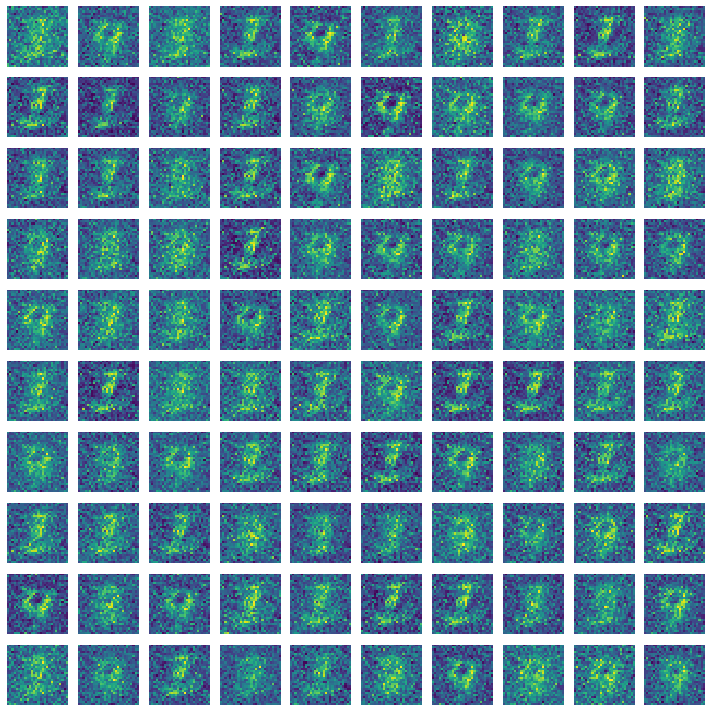

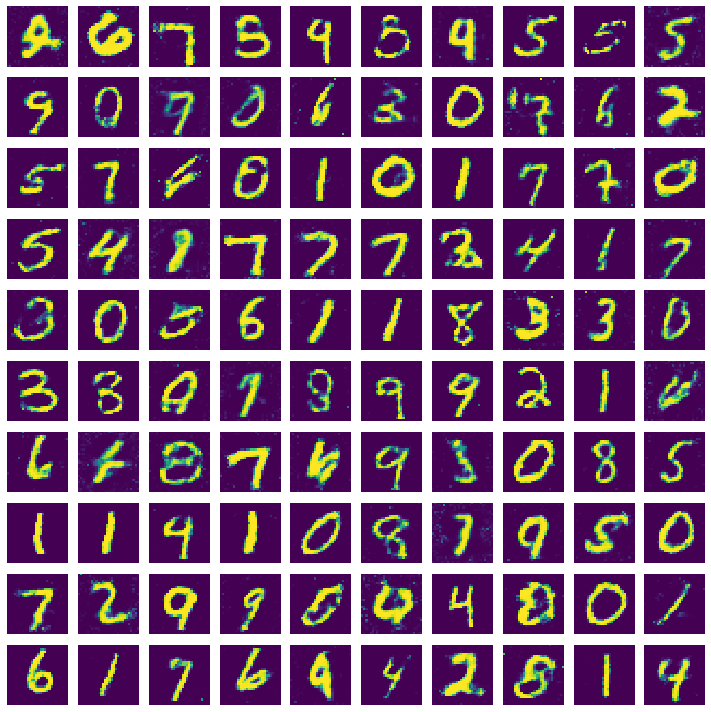

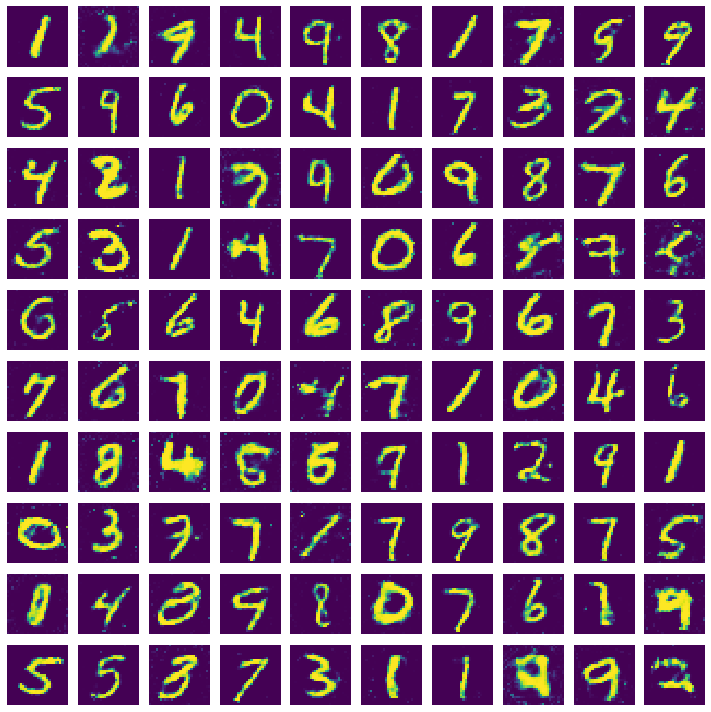

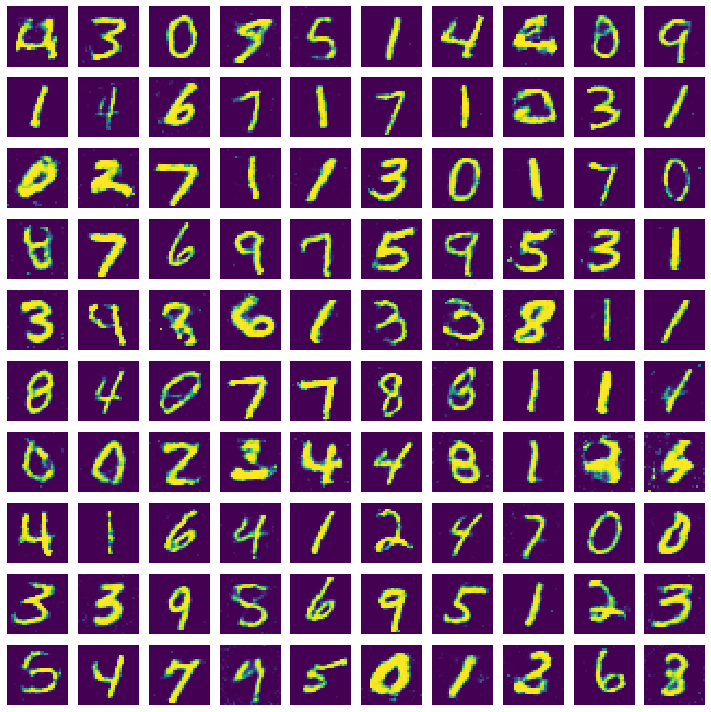

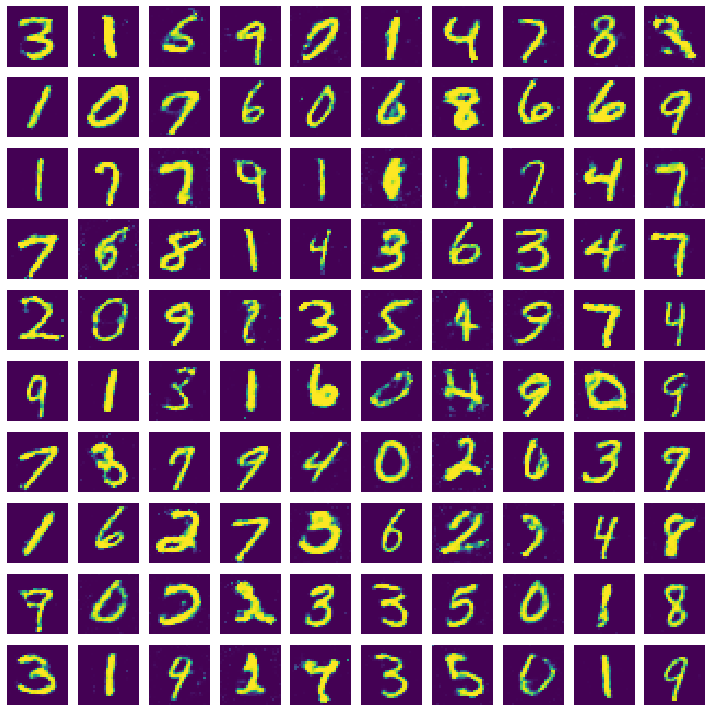

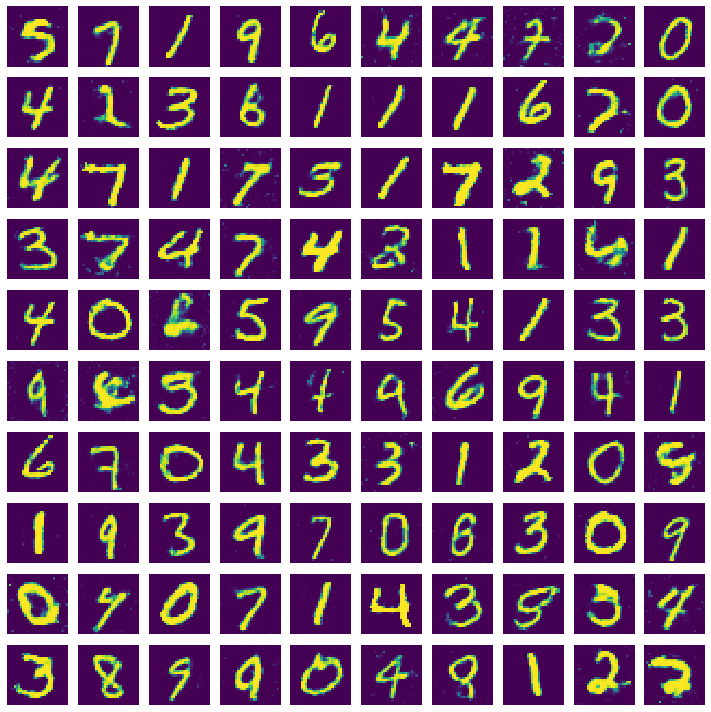

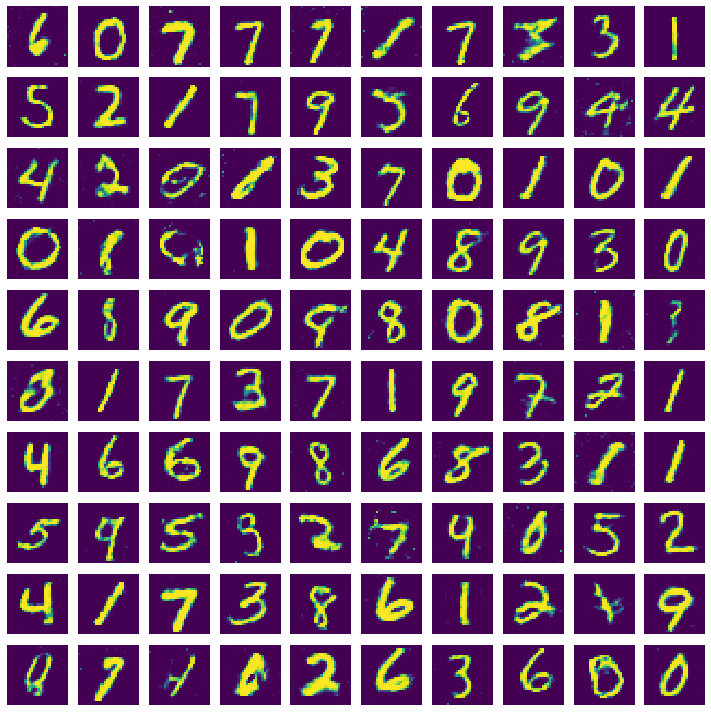

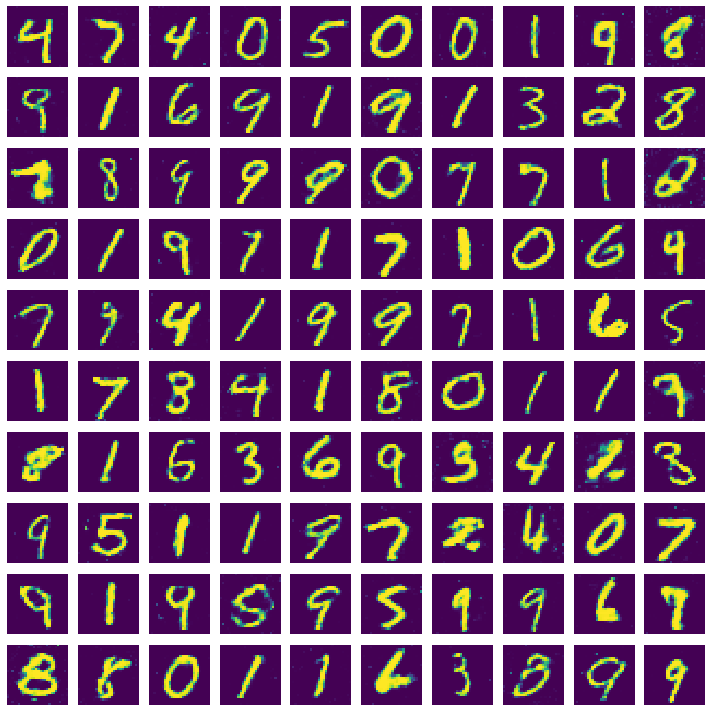

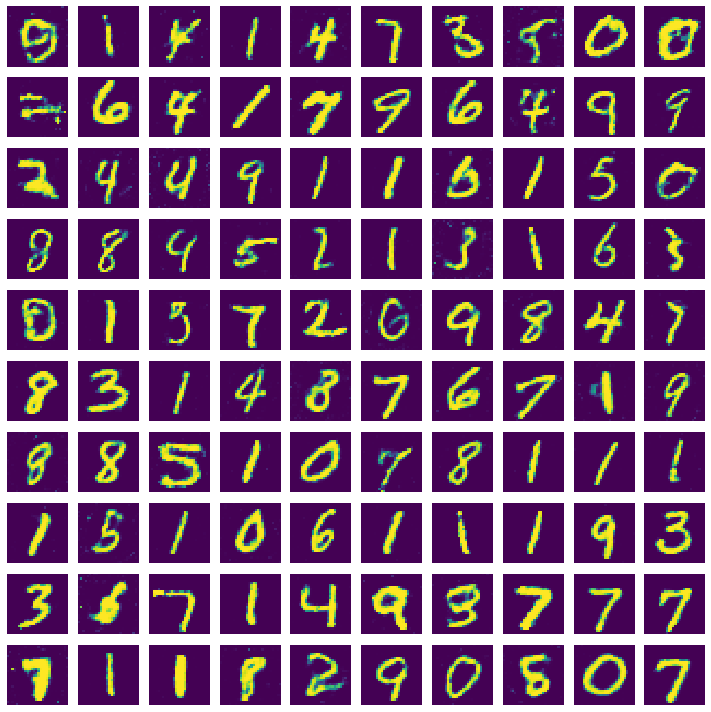

In [16]:
def training(epochs = 1, batch_size = 128):
  (X_train, y_train, X_test, y_test) = load_data()
  batch_count = X_train.shape[0] / batch_size

  generator = create_generator()
  discriminator = create_discriminator()
  gan = create_gan(discriminator, generator)

  for e in range(1, epochs+1):
    print("Epoch %d" %e)
    for _ in tqdm(range(batch_size)):

      noise = np.random.normal(0, 1, [batch_size, 100])

      generated_images = generator.predict(noise)

      image_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=batch_size)]

      X = np.concatenate([image_batch, generated_images])

      y_dis = np.zeros(2*batch_size)
      y_dis[:batch_size] = 0.9

      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)

      noise = np.random.normal(0, 1, [batch_size, 100])
      y_gen = np.ones(batch_size)

      discriminator.trainable = False

      gan.train_on_batch(noise, y_gen)
    if e == 1 or e % 100 == 0:
      plot_generated_images(e, generator)

training(800, 256)

For every 100 epochs, I plot the generated images. After 800 epochs, the generated digits already look like the real digits and for me the generated ones and reals ones are distingushable.

In this homework, I learned how to build up a GAN model from scratch, including creating the generator and discriminator respectively. There are a lot of parameters that I keep changing for this homework so that I could achieve a satisfactory results (at least). The biggest problem for me in this homework is to choose all parameters while creating the generator and discriminator and I just kept trying.